In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from archs.unet import UNetConvNext, UNetEffNet
from archs.convnext_seg import ConvNextSeg
from TrainLoop.data import ConvNextPreprocessor, SemanticSegmentationCOCODataset, CarSegmentationDataset

/home/falkodem/Documents/projects/DamageRecCustom/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/falkodem/Documents/projects/DamageRecCustom/venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [20]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = torch.load('./runs/test_new_labels_focal_woutback/best.pt', map_location='cuda:0')
# model = torch.load('./run/test_old/best.pt', map_location='cuda:0')
model = model.to(device)
model.eval()

size = (768,768)
preprocessor = ConvNextPreprocessor(size, use_imagenet_norm=True)
subset = 'test'
ds_test = SemanticSegmentationCOCODataset(f'../data/car_damage_small/{subset}',
                                        f'../data/car_damage_small/{subset}/_annotations.coco.json',
                                        preprocessor)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/tmp/ipykernel_56963/3068865315.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./runs/test_new_labels_focal_woutback/best.pt', map_location='cuda:0'

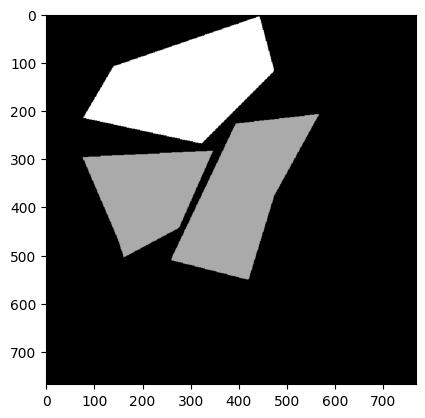

In [21]:
plt.imshow(ds_test[0][1].numpy(), cmap='gray')

In [34]:
i_img = 7
reduced_labels=False
thr = 0.5

id2label = {v['id']: v['name'] for _,v in ds_test.coco_dataset.cats.items()}
id2label[0] = 'фон'
label2id = {name: id_ for id_, name in id2label.items()}
id2color = {0: [0, 0, 0], 1: [200, 0, 0], 2: [108, 64, 20], 3: [255, 229, 204],}# 4: [0, 102, 0], 5: [0, 255, 0], 6: [0, 153, 153], 7: [0, 128, 255], 8: [255, 255, 0]}

GT labels: [(np.uint8(0), 'фон'), (np.uint8(2), 'Dents')]
Pred labels: [(np.int64(0), 'фон'), (np.int64(1), 'Broken')]


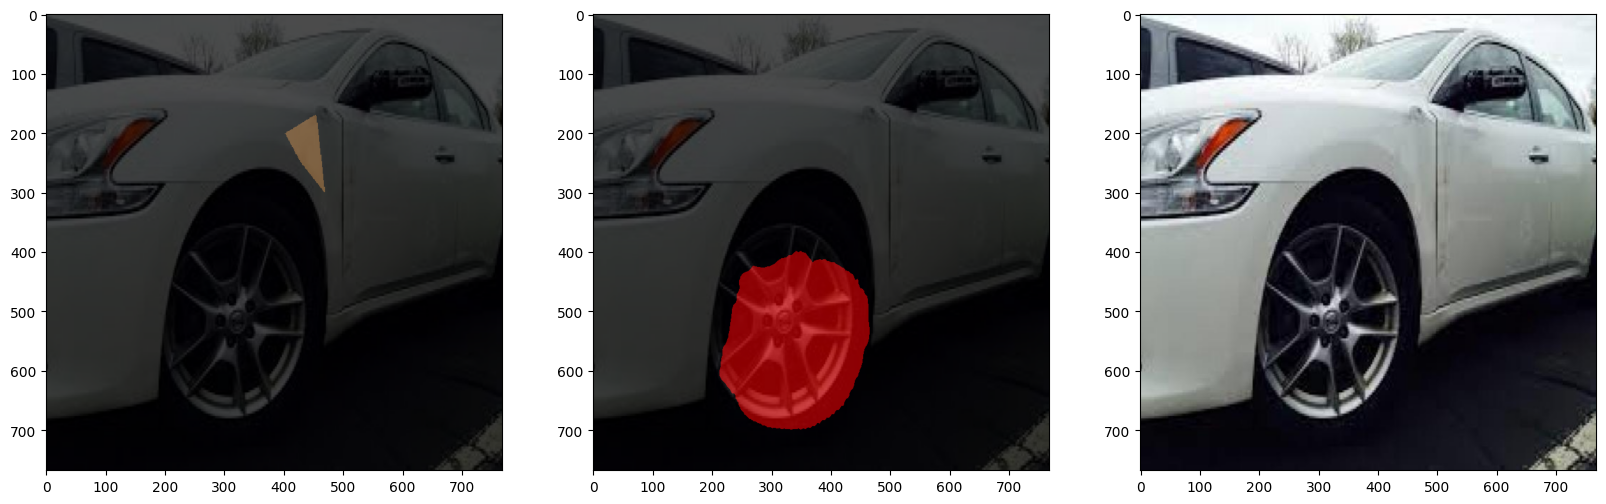

In [35]:
img_path = os.path.join(ds_test.img_dir, ds_test.coco_dataset.imgs[ds_test.idx_mapper[i_img]]['file_name'])
# img_path = ds.img_files[i_img]
orig_img = cv2.imread(img_path)[:,:,::-1]
orig_img = cv2.resize(orig_img, (ds_test.preprocessor.size[1], ds_test.preprocessor.size[0]))

gt = ds_test[i_img][1].detach().numpy().astype(np.uint8)
print('GT labels:', [(idx, id2label[idx]) for idx in np.unique(gt)])
x = ds_test[i_img][0].unsqueeze(0).to(device)
with torch.no_grad():
    model.eval()
    outputs = model(x)
logits = outputs.detach().cpu()
probs = torch.softmax(nn.functional.interpolate(logits,
                size=orig_img.shape[:2], # (height, width)
                mode='bilinear',
                align_corners=False)[0], axis=0).numpy()
# probs = torch.sigmoid(nn.functional.interpolate(logits,
#                 size=orig_img.shape[:2], # (height, width)
#                 mode='bilinear',
#                 align_corners=False)[0]).numpy()
if reduced_labels:
    pred_label = np.argmax(np.concatenate([np.zeros((1, *probs.shape[1:]), dtype=np.float32) + thr,
                                            np.where(probs > thr, probs, 0)], axis=0), axis=0)
else:
    pred_label = np.argmax(probs, axis=0)
    # pred_label = np.argmax(np.where(probs>thr, probs, 0), axis=0)
print('Pred labels:', [(idx, id2label[idx]) for idx in np.unique(pred_label)])

f, ax = plt.subplots(1,3, figsize=(20,7))
color_seg = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[gt == label, :] = color
ax[0].imshow((color_seg*0.7 + orig_img*0.3).astype(np.uint8))

color_seg = np.zeros((pred_label.shape[0], pred_label.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in id2color.items():
    color_seg[pred_label == label, :] = color
ax[1].imshow((color_seg*0.7 + orig_img*0.3).astype(np.uint8))
ax[2].imshow(orig_img)
plt.show()

In [129]:
probs.shape

(4, 768, 768)

In [103]:
label2id

{'фон': 0, 'Broken': 1, 'Dents': 2, 'Scratches': 3}

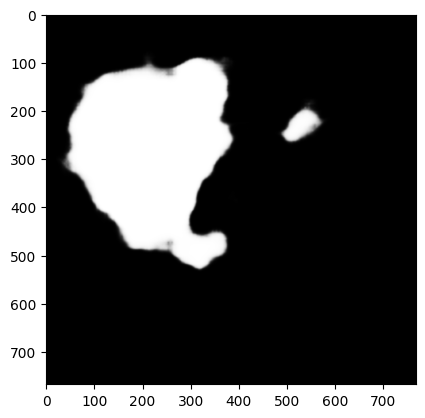

In [65]:
plt.imshow(probs[1], cmap='gray')